In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import os
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import genextreme
import pandas as pd

In [2]:
class LinearNetwork(nn.Module):
    def __init__(self):
        super(LinearNetwork,self).__init__()
        self.fc1=nn.Linear(2,10)
        self.fc2=nn.Linear(10,1)

    def forward(self,x):
        x=self.fc1(x)
        x=self.fc2(x)
        return x

model=LinearNetwork()

In [3]:
class ANN(nn.Module):
    def __init__(self):
        super(ANN,self).__init__()
        self.fc1=nn.Linear(2,10)
        self.fc2=nn.Linear(10,10)
        self.fc3=nn.Linear(10,10)
        self.fc4=nn.Linear(10,1)

    def forward(self,x):
        x=self.fc1(x)
        x=self.fc2(x)
        x=self.fc3(x)
        x=self.fc4(x)
        return x

model2=ANN()

In [4]:
def training_set_output(dataset):
    maximum_ = dataset['TOT_PR'].values
    output = torch.tensor(maximum_, dtype=torch.float32)
    output=output.permute(1, 2, 0)
    return output

In [6]:
class CustomCRPSLoss(nn.Module):
    def __init__(self):
        super(CustomCRPSLoss, self).__init__()

    def forward(self, y_pred, y_true):
        term_one = torch.mean(torch.abs(y_pred - y_true), dim=-1)
        term_two = torch.mean(torch.abs(
        torch.unsqueeze(y_pred, -1) - torch.unsqueeze(y_pred, -2)), dim=(-2, -1))
        half = torch.tensor(-0.5, dtype=term_two.dtype)
        loss = term_one + half * term_two
        loss = torch.mean(loss)
        return loss

In [9]:
"""
path = "/work/FAC/FGSE/IDYST/tbeucler/downscaling/mberthier/repos/Downscaling_CM/data"
os.chdir(path)
train_data=xr.open_dataset('train_data_stationnary.nc')
"""

'\npath = "/work/FAC/FGSE/IDYST/tbeucler/downscaling/mberthier/repos/Downscaling_CM/data"\nos.chdir(path)\ntrain_data=xr.open_dataset(\'train_data_stationnary.nc\')\n'

In [10]:
path = "/work/FAC/FGSE/IDYST/tbeucler/downscaling/mberthier/repos/Downscaling_CM/data"
os.chdir(path)
train_data=xr.open_dataset('train_data_stationnary.nc')

In [11]:
num_weeks = len(train_data['week'])
print("Nombre de semaines :", num_weeks)
train_data

Nombre de semaines : 312


<xarray.Dataset>
Dimensions:  (week: 312, rlat: 101, rlon: 176)
Coordinates:
  * week     (week) int32 12 27 50 20 20 24 48 51 45 ... 5 25 12 10 30 48 52 11
    year     (week) int32 ...
  * rlon     (rlon) float32 -3.0 -2.98 -2.96 -2.94 -2.92 ... 0.44 0.46 0.48 0.5
  * rlat     (rlat) float32 -1.0 -0.98 -0.96 -0.94 -0.92 ... 0.94 0.96 0.98 1.0
Data variables:
    TOT_PR   (week, rlat, rlon) float32 ...

/work/FAC/FGSE/IDYST/tbeucler/downscaling/mberthier/dev_env/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Epoch [10/100], Loss_LNN1: 0.3380
Epoch [10/100], Loss_LNN2: 0.0951
Epoch [20/100], Loss_LNN1: 0.0892
Epoch [20/100], Loss_LNN2: 0.0554
Epoch [30/100], Loss_LNN1: 0.0491
Epoch [30/100], Loss_LNN2: 0.0279
Epoch [40/100], Loss_LNN1: 0.0131
Epoch [40/100], Loss_LNN2: 0.0133
Epoch [50/100], Loss_LNN1: 0.0060
Epoch [50/100], Loss_LNN2: 0.0034
Epoch [60/100], Loss_LNN1: 0.0036
Epoch [60/100], Loss_LNN2: 0.0034
Epoch [70/100], Loss_LNN1: 0.0027
Epoch [70/100], Loss_LNN2: nan
Epoch [80/100], Loss_LNN1: nan
Epoch [80/100], Loss_LNN2: 0.0024
Epoch [90/100], Loss_LNN1: 0.0023
Epoch [90/100], Loss_LNN2: nan
Epoch [100/100], Loss_LNN1: 0.0023
Epoch [100/100], Loss_LNN2: nan


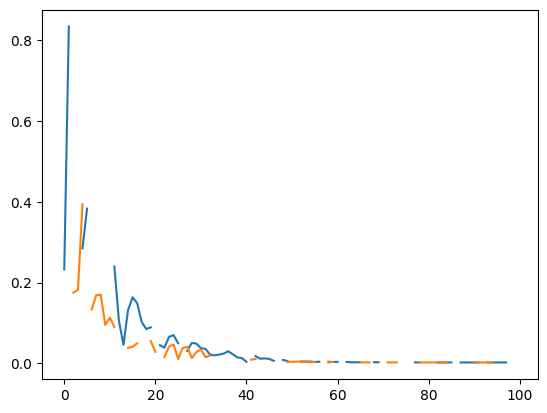

In [12]:
num_epoch=100
train_len=num_weeks
nb_lon= len(train_data['rlon'])
nb_lat= len(train_data['rlat'])

rlat = torch.tensor(train_data['rlat'].values)
rlon=torch.tensor(train_data['rlon'].values)
grid_lat, grid_lon = torch.meshgrid(rlat, rlon)
input = torch.stack((grid_lat, grid_lon), dim=-1)
batch_output=training_set_output(train_data)
batch_output = torch.transpose(batch_output, 0, 1)
optimizer1= torch.optim.Adam(model.parameters(), lr=0.1)
optimizer2= torch.optim.Adam(model2.parameters(), lr=0.1)
loss_crps=CustomCRPSLoss()
loss_list1=[]
loss_list2=[]

for epoch in range(num_epoch):
        #print('EPOCH : ',epoch)
        #print(list(model.parameters()))
        outputs_lnn=model(input)
        outputs_ann=model2(input)
        #print(outputs[1,1,1])

        loc = outputs_lnn[:,:,0]
        size = (nb_lon,nb_lat,batch_output.shape[2])
        u = torch.rand(size)
   

        loc=loc.unsqueeze(-1).repeat(1, 1, size[2])
        loc = torch.transpose(loc, 0, 1)

        ##On fixe xi et scale
    
        c=-0.93
        scale=1e-2
        sample = loc + (torch.pow(-torch.log(u), -c) - 1) * scale / c
        #print('sample',sample)
       
        #print('sample',sample.size())
        #print('batch_output',batch_output.size())
        loss1=loss_crps(sample,batch_output)
        loss_list1.append(torch.detach(loss1).numpy())
        optimizer1.zero_grad()
        loss1.backward()
        optimizer1.step()
        
        ##ANN :
    
        loc2 = outputs_ann[:,:,0]
        size = (nb_lon,nb_lat,batch_output.shape[2])
        u = torch.rand(size)
        ##ON PREND C=1/2 ET SCALE =1
        loc2 = loc2.unsqueeze(-1).repeat(1, 1, size[2])
        loc2 = torch.transpose(loc2, 0, 1)

        sample = loc2 + (torch.pow(-torch.log(u), -c) - 1) * scale / c
    
        loss2=loss_crps(sample,batch_output)
        loss_list2.append(torch.detach(loss2).numpy())
        optimizer2.zero_grad()
        loss2.backward()
        optimizer2.step()
    
        if (epoch+1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epoch}], Loss_LNN1: {loss1.item():.4f}')
            print(f'Epoch [{epoch+1}/{num_epoch}], Loss_LNN2: {loss2.item():.4f}')
plt.plot(loss_list1)
plt.plot(loss_list2)
plt.show()

In [14]:
loss_list2

[array(nan, dtype=float32),
 array(nan, dtype=float32),
 array(0.1753998, dtype=float32),
 array(0.18183185, dtype=float32),
 array(0.39380777, dtype=float32),
 array(nan, dtype=float32),
 array(0.13330474, dtype=float32),
 array(0.16857061, dtype=float32),
 array(0.17012577, dtype=float32),
 array(0.09506638, dtype=float32),
 array(0.1131053, dtype=float32),
 array(0.09041678, dtype=float32),
 array(nan, dtype=float32),
 array(nan, dtype=float32),
 array(0.03837067, dtype=float32),
 array(0.04120442, dtype=float32),
 array(0.0496085, dtype=float32),
 array(nan, dtype=float32),
 array(nan, dtype=float32),
 array(0.05536828, dtype=float32),
 array(0.02857907, dtype=float32),
 array(nan, dtype=float32),
 array(0.01579191, dtype=float32),
 array(0.04195919, dtype=float32),
 array(0.04670213, dtype=float32),
 array(0.01085546, dtype=float32),
 array(0.03810758, dtype=float32),
 array(0.04104039, dtype=float32),
 array(0.01326094, dtype=float32),
 array(0.02791807, dtype=float32),
 array(0.

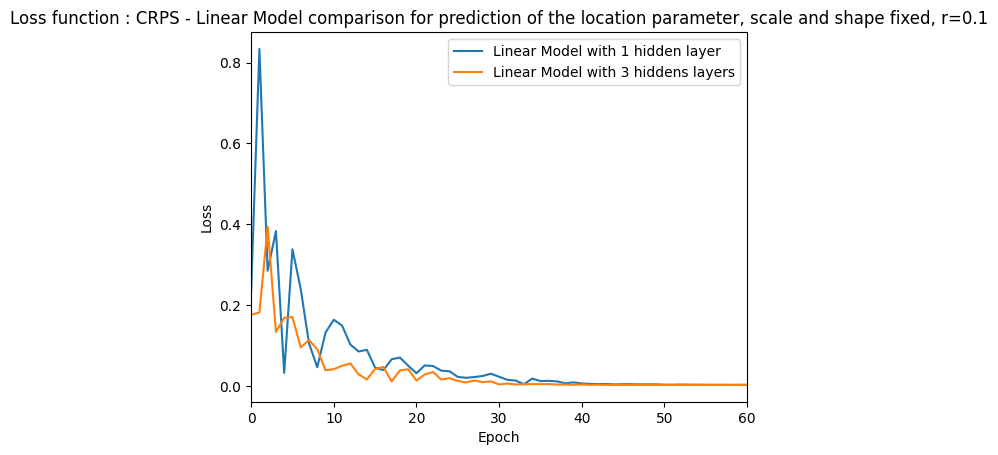

In [20]:
plt.plot([x for x in loss_list1 if x<10],label='Linear Model with 1 hidden layer')
plt.plot([x for x in loss_list2 if x<10], label='Linear Model with 3 hiddens layers')

plt.title('Loss function : CRPS - Linear Model comparison for prediction of the location parameter, scale and shape fixed, r=0.1')
plt.xlim(0,60)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
##On rajoute la température :

In [21]:
input_variable=pd.read_csv('lausanne_dataset_variables')

In [22]:
##Réseau de neurones linéaire pour prédire le location parameter avec 3 entrées 

In [23]:
class LinearNetwork(nn.Module):
    def __init__(self):
        super(LinearNetwork,self).__init__()
        self.fc1=nn.Linear(3,10)
        self.fc2=nn.Linear(10,1)

    def forward(self,x):
        x=self.fc1(x)
        x=self.fc2(x)
        return x

model=LinearNetwork()

In [24]:
num_epoch=10
train_len=num_weeks
nb_lon= len(input_variable['rlon'])
nb_lat= len(input_variable['rlat'])

temp= torch.tensor(input_variable['temperature'])

rlat = torch.tensor(input_variable['rlat'])
rlon = torch.tensor(input_variable['rlon'])

input= torch.stack((rlat,rlon,temp),dim=-1)

##on restreint train_data à lausanne : 
lat_bnd = [-0.5, -0.3]
lon_bnd = [-2.4,-2.3]
train_data_bis=train_data.sel(rlon=slice(*lon_bnd), rlat=slice(*lat_bnd))

batch_output = training_set_output(train_data_bis)
batch_output = torch.reshape(batch_output, (batch_output.size(0) * batch_output.size(1), batch_output.size(2)))
optimizer1 = torch.optim.Adam(model.parameters(), lr=0.1)
loss_crps=CustomCRPSLoss()
loss_list1=[]

In [25]:
batch_output.size()

torch.Size([66, 312])

Epoch [10/100], Loss: 30.5006
Epoch [20/100], Loss: 6.5682
Epoch [30/100], Loss: 1.8781
Epoch [40/100], Loss: 1.4769
Epoch [50/100], Loss: 1.1380
Epoch [60/100], Loss: 3.3323
Epoch [70/100], Loss: 0.9492
Epoch [80/100], Loss: 0.3632
Epoch [90/100], Loss: 0.3563
Epoch [100/100], Loss: 0.1071


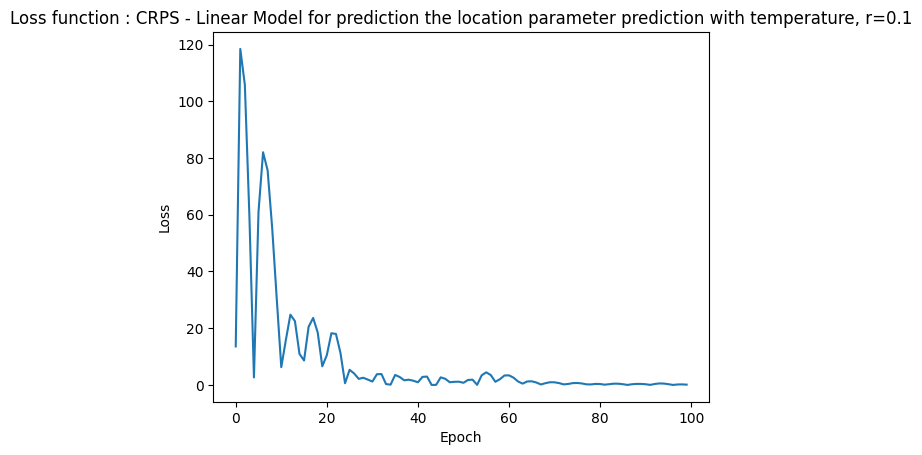

In [26]:
num_epoch=100
for epoch in range(num_epoch):
        
        outputs_lnn = model(input.float())


        loc = outputs_lnn[:,0]
        size = (66,batch_output.shape[1])
        u = torch.rand(size)
        
        loc = loc.unsqueeze(-1).repeat(1, 1, size[1])
        loc = torch.transpose(loc, 0, 1)

        c=-0.93
        scale=1e-2
        sample = loc + (torch.pow(-torch.log(u), -c) - 1) * scale / c
        #print('sample',sample)
       
        #print('sample',sample.size())
        #print('batch_output',batch_output.size())
    
        loss1=loss_crps(sample,batch_output)
        loss_list1.append(torch.detach(loss1).numpy())
        optimizer1.zero_grad()
        loss1.backward()
        optimizer1.step()
        
    
        if (epoch+1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epoch}], Loss: {loss1.item():.4f}')
plt.plot(loss_list1)
plt.title('Loss function : CRPS - Linear Model for prediction the location parameter prediction with temperature, r=0.1')
plt.xlabel('Epoch')
plt.ylabel('Loss')
#plt.legend()
plt.show()

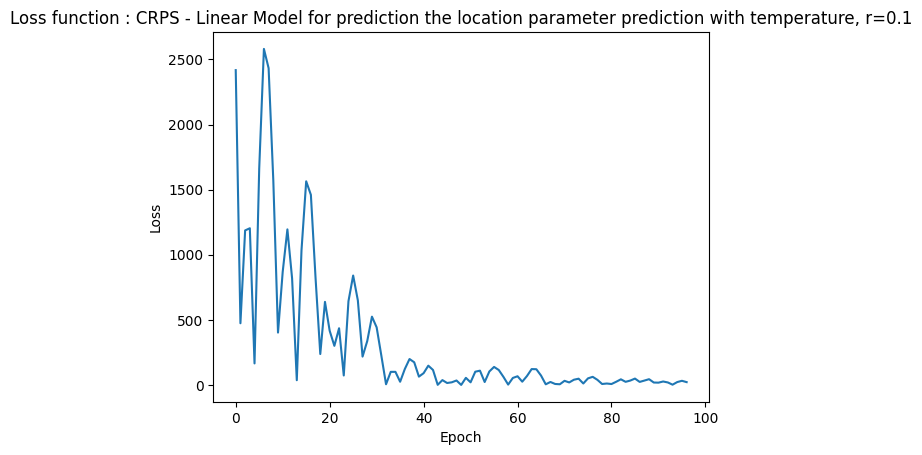

In [87]:
plt.plot(loss_list1[3:])
plt.title('Loss function : CRPS - Linear Model for prediction the location parameter prediction with temperature, r=0.1')
plt.xlabel('Epoch')
plt.ylabel('Loss')
#plt.legend()
plt.show()